In [ ]:
import zipfile

# Extracting ZIP file for the images and CSV file
with zipfile.ZipFile('/content/Image_classification_data.zip', 'r') as zip_ref:
    zip_ref.extractall('./')

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
from tensorflow import keras
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from tensorflow.keras import datasets, layers, models
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization

# Splitting the Dataset

In [ ]:
data_main = pd.read_csv('/content/data_labels_mainData.csv')
data_main = data_main[['ImageName', 'cellType']]
data_main['cellType'] = data_main['cellType'].astype('str')
#Splitting data into train, test and validation
train_data, test_data = train_test_split(data_main, test_size=0.2, random_state=0)
train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=0)

print("Train data : {}, Val Data: {}, Test Data: {}".format(train_data.shape[0], val_data.shape[0], test_data.shape[0]))

Train data : 5937, Val Data: 1979, Test Data: 1980


<ipython-input-3-bfe94a99d07e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_main['cellType'] = data_main['cellType'].astype('str')


In [ ]:
def plot_learning_curve(train_loss, val_loss, train_metric, val_metric, metric_name='Accuracy'):
    plt.figure(figsize=(10,5))
    
    plt.subplot(1,2,1)
    plt.plot(train_loss, 'r--')
    plt.plot(val_loss, 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(train_metric, 'r--')
    plt.plot(val_metric, 'b--')
    plt.xlabel("epochs")
    plt.ylabel(metric_name)
    plt.legend(['train', 'val'], loc='upper left')

    plt.show()

# Model

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2

batch_size=64

# Define data generators for training, validation, and testing sets
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    rescale=1./255,
    shear_range=0.2,
    fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_data,
    directory='/content/patch_images',
    x_col="ImageName",
    y_col="cellType",
    target_size=(64, 64),
    batch_size=batch_size,
    class_mode='categorical')

valid_generator = val_datagen.flow_from_dataframe(
    dataframe=val_data,
    directory='/content/patch_images',
    x_col="ImageName",
    y_col="cellType",
    target_size=(64, 64),
    batch_size=batch_size,
    class_mode='categorical')

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_data,
    directory='/content/patch_images',
    x_col="ImageName",
    y_col="cellType",
    target_size=(64, 64),
    batch_size=batch_size,
    class_mode='categorical')

# Create an instance of the VGG16 model with imagenet weights
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

# Freeze the first few layers in the VGG16 model and keep the later layers trainable
for layer in vgg16.layers[:10]:
    layer.trainable = False

# Add custom layers on top of the VGG16 model with L2 regularization and dropout
x = vgg16.output
x = Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.05))(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.05))(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu', kernel_regularizer=l2(0.05))(x)
x = Dropout(0.5)(x)

predictions = Dense(4, activation='softmax')(x)

model = Model(inputs=vgg16.input, outputs=predictions)

model.compile(loss='categorical_crossentropy',
optimizer='adam',
metrics=['accuracy'])

early_stop = EarlyStopping(patience=10, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(factor=0.1, patience=5, verbose=1)

history = model.fit(train_generator,
steps_per_epoch=train_generator.n // batch_size,
validation_data=valid_generator,
validation_steps=valid_generator.n // batch_size,
epochs=100,
callbacks=[early_stop, reduce_lr])

Found 5937 validated image filenames belonging to 4 classes.
Found 1979 validated image filenames belonging to 4 classes.
Found 1980 validated image filenames belonging to 4 classes.
58889256/58889256 [==============================] - 1s 0us/step
Epoch 1/100
92/92 [==============================] - 32s 143ms/step - loss: 9.4824 - accuracy: 0.3817 - val_loss: 3.7093 - val_accuracy: 0.4182 - lr: 0.0010
Epoch 2/100
92/92 [==============================] - 11s 124ms/step - loss: 2.2905 - accuracy: 0.4105 - val_loss: 1.5647 - val_accuracy: 0.4224 - lr: 0.0010
Epoch 3/100
92/92 [==============================] - 12s 128ms/step - loss: 1.4011 - accuracy: 0.4401 - val_loss: 1.3023 - val_accuracy: 0.4214 - lr: 0.0010
Epoch 4/100
92/92 [==============================] - 12s 128ms/step - loss: 1.1511 - accuracy: 0.5513 - val_loss: 1.0742 - val_accuracy: 0.5651 - lr: 0.0010
Epoch 5/100
92/92 [==============================] - 13s 136ms/step - loss: 1.0412 - accuracy: 0.5982 - val_loss: 0.9321 - v

# Metrics and learning curve

In [ ]:
model.evaluate(train_generator)
model.evaluate(test_generator)
model.evaluate(valid_generator)

31/31 [==============================] - 2s 73ms/step - loss: 0.6225 - accuracy: 0.7731


[0.622515082359314, 0.77311772108078]

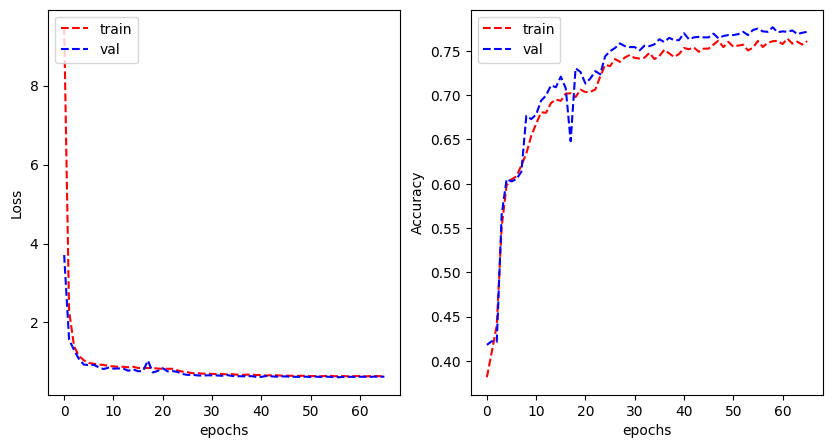

In [ ]:
plot_learning_curve(history.history['loss'],history.history['val_loss'], 
                    history.history['accuracy'], history.history['val_accuracy'], 
                    metric_name='Accuracy')